<a href="https://colab.research.google.com/github/Ssurf777/Generative3D_Face_VAE/blob/main/ply_%3ESDF_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --- パッケージインストール ---
!pip install -q POT open3d wandb trimesh matplotlib numpy scipy rtree shapely pyvista panel vtk ipyvtklink jupyter_bokeh
!apt-get update -y && apt-get install -y libgl1-mesa-glx xvfb

# --- 標準ライブラリ ---
import os
import itertools
import requests

# --- 科学計算 / 可視化系 ---
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
from skimage import measure
import torch
import torch.nn.functional as F
import torch.optim as optim

# --- 3D可視化系 ---
import trimesh
import pyvista as pv
import panel as pn
import plotly.graph_objects as go

# --- PyVista環境設定 ---
pn.extension('vtk')
pv.start_xvfb()

# --- 外部ファイルのダウンロード ---
def download_file(url, local_filename):
    print(f"Downloading {url}...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):
                    f.write(chunk)
        print(f"{local_filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {local_filename}: {e}")

# ダウンロード対象のURL一覧
urls = {
    "utils.py": "https://raw.githubusercontent.com/Ssurf777/Generative3D_Face_VAE/refs/heads/main/lib/utils.py",
    "ply_dataloader2.py": "https://raw.githubusercontent.com/Ssurf777/Generative3D_Face_VAE/refs/heads/main/lib/ply_dataloader2.py",
    "sampling.py": "https://raw.githubusercontent.com/Ssurf777/Generative3D_Face_VAE/refs/heads/main/lib/sampling.py",
    "ISAB_VQVAE.py": "https://raw.githubusercontent.com/Ssurf777/Generative3D_Face_VAE/refs/heads/main/lib/ISAB_VQVAE.py",
    "ChamferDis.py": "https://raw.githubusercontent.com/Ssurf777/Generative3D_Face_VAE/refs/heads/main/lib/ChamferDis.py",
    "EarthMoversDis.py": "https://raw.githubusercontent.com/Ssurf777/Generative3D_Face_VAE/refs/heads/main/lib/EarthMoversDis.py",
    "visualize_loss.py": "https://raw.githubusercontent.com/Ssurf777/Generative3D_Face_VAE/refs/heads/main/lib/visualize_loss.py",
    "ISAB.py": "https://raw.githubusercontent.com/Ssurf777/Generative3D_Face_VAE/refs/heads/main/lib/ISAB.py",
}

for filename, url in urls.items():
    download_file(url, filename)

# --- 自作モジュールのインポート ---
import utils
import sampling
import ISAB_VQVAE
import ISAB
import ply_dataloader2
import ChamferDis
import EarthMoversDis
import visualize_loss

from utils import get_available_memory
from sampling import PointSampler
from ISAB import MultiheadAttentionBlock, ISAB
from ISAB_VQVAE import ISAB_VQVAE
from ply_dataloader2 import prepare_data_from_ply
from ChamferDis import chamfer_distance
from EarthMoversDis import emd_distance
from visualize_loss import visualize_loss

# メモリ確認
available_memory_gb = get_available_memory()
print(f"Available memory: {available_memory_gb:.2f} GB")



Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 129 kB in 1s (86.2 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Don

/usr/local/lib/python3.11/dist-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


utils.py downloaded successfully.
ply_dataloader2.py downloaded successfully.
sampling.py downloaded successfully.
ISAB_VQVAE.py downloaded successfully.
ChamferDis.py downloaded successfully.
EarthMoversDis.py downloaded successfully.
visualize_loss.py downloaded successfully.
ISAB.py downloaded successfully.
Available memory: 10.56 GB


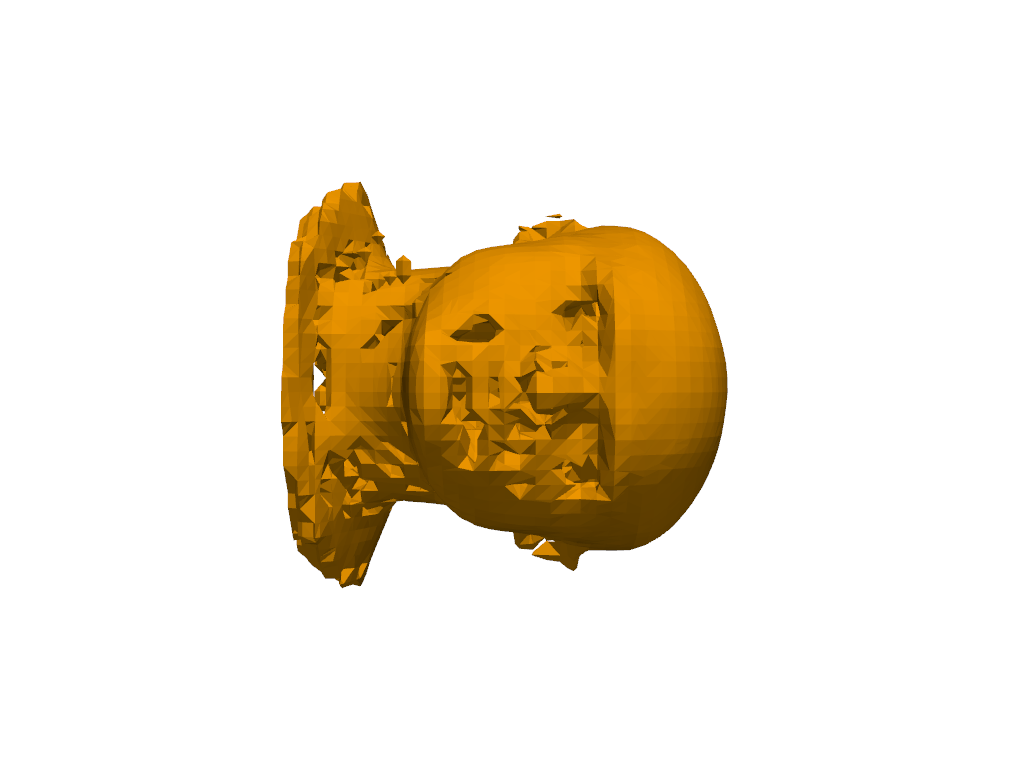

In [3]:

# --- メッシュ読み込みとSDF処理 ---
mesh = trimesh.load("/content/drive/MyDrive/Emotional_fase_datasets/mouth_open/mouth_open.000020.ply")

grid_size = 32
vmin, vmax = mesh.bounds
grid_lin = [np.linspace(vmin[i], vmax[i], grid_size) for i in range(3)]
X, Y, Z = np.meshgrid(*grid_lin, indexing='ij')
grid_points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

sdf_values = mesh.nearest.signed_distance(grid_points)
sdf_volume = sdf_values.reshape((grid_size, grid_size, grid_size))

# --- Marching Cubesでメッシュ生成 ---
verts, faces, normals, _ = measure.marching_cubes(sdf_volume, level=0.0)
faces_pv = np.hstack([np.full((faces.shape[0], 1), 3), faces])
mesh_pv = pv.PolyData(verts, faces_pv)

# --- 可視化 ---
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(mesh_pv, color='orange', opacity=1.0)
plotter.view_vector([0, 0, 1])  # +z方向
plotter.show(jupyter_backend='panel')

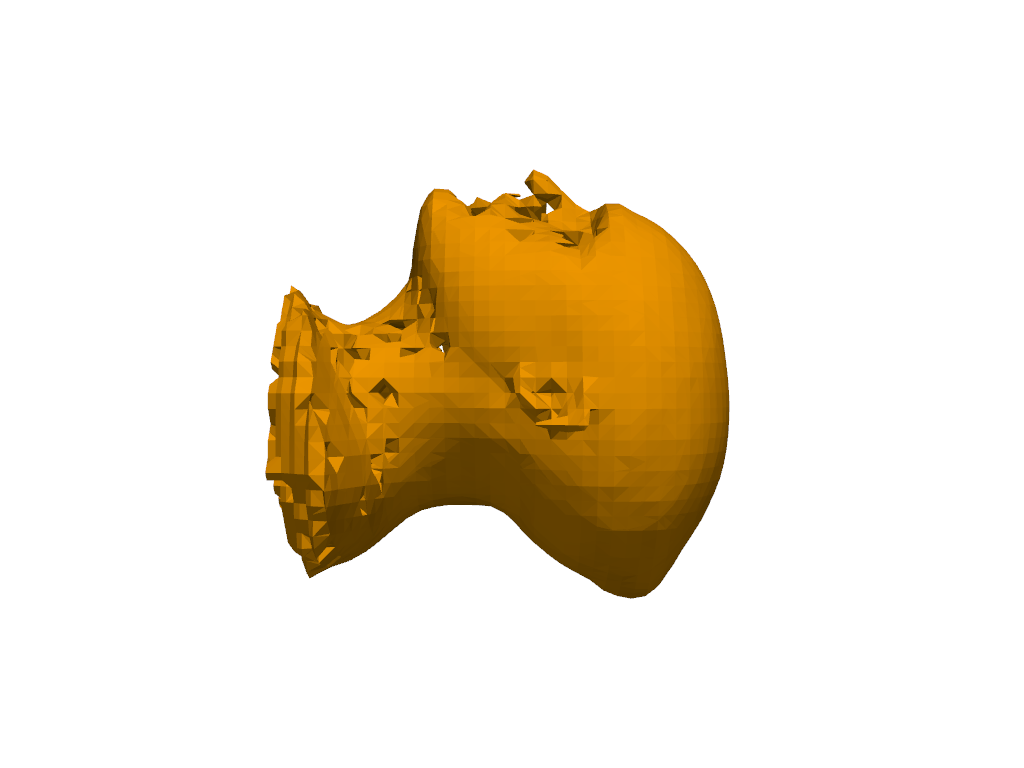

In [4]:
# --- 可視化 ---
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(mesh_pv, color='orange', opacity=1.0)
plotter.view_vector([1, 0, 0])  # +z方向
plotter.show(jupyter_backend='panel')

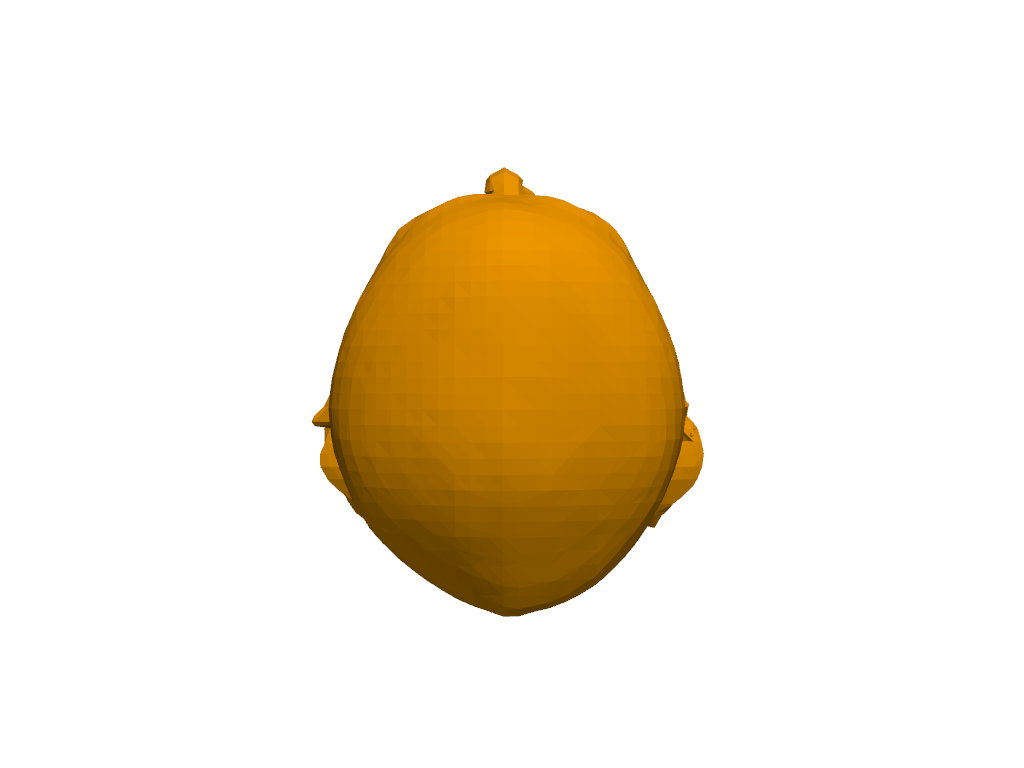

In [5]:
# --- 可視化 ---
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(mesh_pv, color='orange', opacity=1.0)
plotter.view_vector([0, 1, 0])  # +z方向
plotter.show(jupyter_backend='panel')